# Dataset 3

## Initial imports and dataset structuring

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer()
Input = tf.keras.layers.Input
Embedding = tf.keras.layers.Embedding
Dense = tf.keras.layers.Dense
Concatenate = tf.keras.layers.Concatenate
Model = tf.keras.Model
simpleRNN = tf.keras.layers.SimpleRNN
LSTM = tf.keras.layers.LSTM
GRU = tf.keras.layers.GRU
dropout = tf.keras.layers.Dropout

import nltk
from nltk.corpus import stopwords
""" import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:y

    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context """

nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wnl = WordNetLemmatizer()

import re
import numpy as np

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alkakumari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alkakumari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
pd.options.display.max_colwidth = 300
df = pd.read_csv('../data/english_dataset/english_dataset.tsv', sep='\t')

### Dropping Unnecessary columns
task_1 is binary classification. We do not need it. Hence, task_1 is being dropped.
task_3 tells us whether a text is target or not. This is out of scope. Hence dropping task_3.
text_id is being dropped as it will give no useful information to my model.

In [27]:
df.drop(['text_id','task_1','task_3'], axis=1, inplace=True)
df.rename(columns={'task_2':'class'}, inplace=True)
df['class'].value_counts()

class
NONE    3591
HATE    1143
PRFN     667
OFFN     451
Name: count, dtype: int64

#### Making class labels as 0,1,2
There are 4 classes here which we can convert to our familiar labels as below:

<table>
<tr>
<td>This datatset class</td>
<td>Parent class</td>
</tr>
<tr>
<td>HATE</td>
<td>0</td>
</tr>
<tr>
<td>PRFN, OFFN</td>
<td>1</td>
</tr>
<tr>
<td>NONE</td>
<td>2</td>
</tr>
</table>

In [28]:
df['class'] = df['class'].apply(lambda x: 0 if x == 'HATE'
                   else 1 if (x == 'PRFN' or x == 'OFFN')
                   else 2)  
df.value_counts()

text                                                                                                                                                                                                                                                                 class
By wearing the #BalidaanBadge over his gloves @msdhoni has shown his love &amp; respect for the forces.     @icc should understand that this is not related to any political/religious/racial activities    This is about our #NationalPride    #DhoniKeepsTheGlove  2        5
500 doctors have already resigned in #Bengal.    NRS 100  SSKM 175  National medical college 20  RG Kar 126  North Bengal college 119  Murshidabad 50  Rampurhat 37  Burdwan 26    #DoctorsFightBack #SaveTheDoctors                                                 2        4
They heal, operate, diagnose  We consider them a part of the second God cosmos  This is so appalling, shameful and gross  We need to bring this violence to a close    #SaveBengal  #DoctorsF

## EDA

In [29]:
df.isnull().sum()

text     0
class    0
dtype: int64

### Preprocessing

In [30]:
stopwords = stopwords.words('english')
stopwords.append('&amp;') # &amp; means and
def clean(df):
    df['text'] = df['text'].apply(lambda x: x.lower()) #lowercase
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])) #stopwords removal
    df['text'] = df['text'].apply(lambda x: re.sub(r'@[A-Za-z0-9]*', '', x)) #replace all @mentions to ''
    df['text'] = df['text'].apply(lambda x: re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'URL', x)) #replace all urls to 'URL'
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x)) #remove punctuation
    punct = '!"$%&\'()*+,-./:;<=>?[\\]^_{|}~'
    df['text'] = df['text'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punct)))
    df['text'] = df['text'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='a') for word in x.split()])) #lemmatize on the basis of adjectives
    df['text'] = df['text'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='v') for word in x.split()])) #lemmatize on the basis of verbs
    df['text'] = df['text'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='n') for word in x.split()])) #lemmatize on the basis of noun
    df['text'] = df['text'].apply(lambda x: re.sub(r'\bRT\b', '', x)) #remove RT
    return df

In [31]:
def tokenize(df):
    df['text'] = tokenizer.texts_to_sequences(df['text'])
    vocab_size = len(tokenizer.word_index) + 1
    padded_text = pad_sequences(df['text'].tolist(), padding='post', maxlen=MAX_SEQ_LEN)
    return padded_text, vocab_size

def preprocess(df):
    df, vocab_size = tokenize(df)
    return df, vocab_size

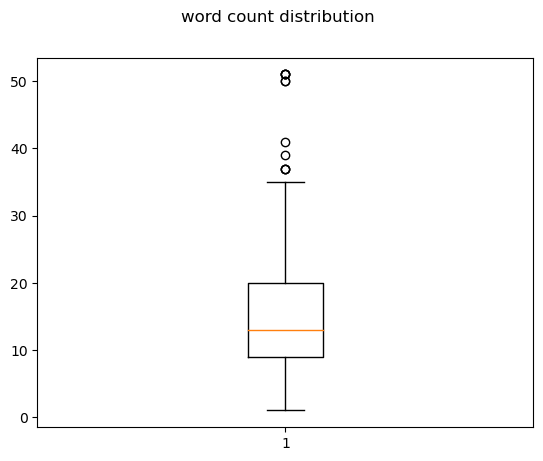

Training Shape: (4681, 1)
Validation Shape: (1171, 1)


In [32]:
df = clean(df)
plt.suptitle('word count distribution')
plt.boxplot([len(x.split()) for x in df['text']])
plt.show()
#print(df[df['text'].apply(lambda x: len(x.split()) > 40)])
X = df.drop(columns=['class'])
Y = df['class']
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=54)
print("Training Shape:", X_train.shape)
print("Validation Shape:", X_val.shape) 

In [33]:
MAX_SEQ_LEN = 30

<Figure size 640x480 with 0 Axes>

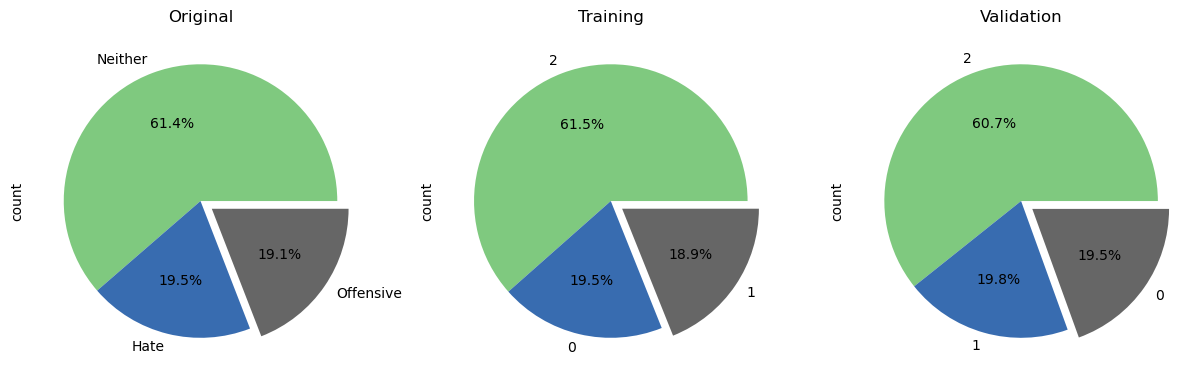

In [34]:
plt.suptitle('Class Distribution')
plt.figure(figsize=(15, 5))
explode = (0, 0, 0.1)
plt.subplot(1, 3, 1)
df['class_labels'] = df['class'].map({0: 'Hate', 1: 'Offensive', 2: 'Neither'})
df['class_labels'].value_counts().plot(kind='pie', title='Original', colormap='Accent', 
                                      autopct='%1.1f%%',
                                      explode=explode,
                                      )
plt.subplot(1, 3, 2)
Y_train.value_counts().plot.pie(title='Training', colormap='Accent', autopct='%1.1f%%',
                                explode=explode)
plt.subplot(1, 3, 3)
Y_val.value_counts().plot.pie(title='Validation', colormap='Accent', autopct='%1.1f%%',
                                explode=explode)
plt.show()
df.drop(columns=['class_labels'], inplace=True)

In [35]:
tokenizer.fit_on_texts(X_train['text'])
X_train, vocab_size = preprocess(X_train)
X_val, _ = preprocess(X_val)
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 11563


In [36]:
# import os
# import requests
# import zipfile

# # Define the URL for the GloVe embeddings
# glove_url = "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
# glove_zip_file = "glove.twitter.27B.zip"

# # Download the embeddings
# response = requests.get(glove_url, stream=True)
# with open(glove_zip_file, "wb") as file:
#     for chunk in response.iter_content(chunk_size=128):
#         file.write(chunk)

# # Extract the embeddings
# with zipfile.ZipFile(glove_zip_file, "r") as zip_ref:
#     zip_ref.extractall("glove_embeddings")

### Embedding

In [ ]:
word_index = tokenizer.word_index
embedding_index = {}
with open('glove_embeddings/glove.twitter.27B.200d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
# Create embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [37]:
word_index

{'url': 1,
 'fucktrump': 2,
 'trumpisatraitor': 3,
 'trump': 4,
 'doctorsfightback': 5,
 'dhonikeepstheglove': 6,
 'shameonicc': 7,
 'doctor': 8,
 'get': 9,
 'borisjohnsonshouldnotbepm': 10,
 'say': 11,
 'icc': 12,
 'murderer': 13,
 'people': 14,
 'u': 15,
 'like': 16,
 'world': 17,
 'go': 18,
 'rapist': 19,
 'douchebag': 20,
 'it': 21,
 'know': 22,
 'one': 23,
 'india': 24,
 'country': 25,
 'resist': 26,
 'time': 27,
 'take': 28,
 'think': 29,
 'see': 30,
 'rain': 31,
 'cricket': 32,
 'make': 33,
 'cup': 34,
 'fuck': 35,
 'dhoni': 36,
 'glove': 37,
 'dickhead': 38,
 'would': 39,
 'match': 40,
 'day': 41,
 'good': 42,
 'want': 43,
 'support': 44,
 'need': 45,
 'even': 46,
 'cwc19': 47,
 'lie': 48,
 'cant': 49,
 'resisttrump': 50,
 'you': 51,
 'he': 52,
 'call': 53,
 'right': 54,
 'come': 55,
 'give': 56,
 'johnmccainday': 57,
 'indian': 58,
 'doctorsprotest': 59,
 'year': 60,
 'show': 61,
 'happy': 62,
 'president': 63,
 'look': 64,
 'savethedoctors': 65,
 'stop': 66,
 'let': 67,
 'bor

In [ ]:
print("Word Index Length:", len(word_index))
print("Embedding Matrix Shape:", embedding_matrix.shape)

In [ ]:
Y_train.astype(int)

In [ ]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train.astype(int))
class_weights = dict(enumerate(class_weights))
#If class weight is used, y needs to be one-hot encoded
Y_train_encoded = tf.keras.utils.to_categorical(Y_train, num_classes=3)
Y_val_encoded = tf.keras.utils.to_categorical(Y_val, num_classes=3)

In [ ]:
learning_rate = 0.00003

In [ ]:
def model_LSTM(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(input_length,), name='text_input')
    x = Embedding(input_dim=vocab_size+1, output_dim=128, input_length=input_length)(text_input)
    x = LSTM(500, return_sequences=True)(x)
    x = dropout(0.8)(x)
    x = LSTM(300)(x)
    x = dropout(0.7)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def model_RNN(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(input_length,), name='text_input')
    x = Embedding(input_dim=vocab_size+1, output_dim=128, 
                  input_length=MAX_SEQ_LEN)(text_input)
    x = simpleRNN(500)(x)
    x = dropout(0.8)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def model_GRU(vocab_size, input_length=MAX_SEQ_LEN):
    learning_rate = 0.00001
    text_input = Input(shape=(input_length,), name='text_input')
    x = Embedding(input_dim=vocab_size+1, output_dim=128, input_length=MAX_SEQ_LEN)(text_input)
    x = GRU(500)(x)
    x = dropout(0.8)(x)
    #add_input = Input(shape=(4,), name='additional_input')
    #x = Concatenate()([x, add_input])
    #x = Dense(64, activation='relu')(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def novel_model(vocab_size, input_length=MAX_SEQ_LEN, learning_rate=0.00003):
    Bidirectional = tf.keras.layers.Bidirectional
    model = tf.keras.Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=200, 
                        weights=[embedding_matrix], 
                        input_length=input_length, 
                        trainable=False))
    model.add(Bidirectional(GRU(40, activation='relu', return_sequences=True, name='BiDirectionalGRUlayer'))) #GRU layer with 40 units
    model.add(dropout(0.3)) #Dropout layer to prevent overfitting
    model.add(Bidirectional(LSTM(20, recurrent_activation='relu', return_sequences=True))) #LSTM layer with 20 units
    model.add(dropout(0.3)) #Dropout layer to prevent overfitting
    model.add(Dense(15)) #Dense layer with 16 units and relu activation function
    model.add(dropout(0.3)) #Dropout layer to prevent overfitting
    model.add(simpleRNN(10)) #SimpleRNN layer with 10 units
    model.add(Dense(10)) #Dense layer with 16 units and relu activation function
    model.add(Dense(3, activation='softmax')) #Output layer with 3 units and softmax activation function
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, use_ema=True, ema_momentum=0.9)
    model.compile(optimizer=optimizer, loss='mean_squared_logarithmic_error', metrics=['accuracy'])
    return model

In [ ]:
def train(model, X_train, Y_train, X_val, Y_val, epochs=100, batch_size=64):
      callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=6,
                                                      mode='min',
                                                      restore_best_weights=True)
      history = model.fit(X_train, Y_train, 
            validation_data=(X_val, Y_val), 
            epochs=epochs, batch_size=batch_size, 
            class_weight=class_weights,
            callbacks=callback,
            shuffle=True,
            verbose=2)
      print("\n\n****************************\n\n")
      print("Model trained successfully")
      pred = model.predict(X_val, batch_size=batch_size, verbose=1, steps=None)
      
      y_true = np.argmax(Y_val, axis=1)
      y_pred = np.argmax(pred, axis=1)
      precision = precision_score(y_true, y_pred, average='weighted')
      recall = recall_score(y_true, y_pred, average='weighted')
      f1 = f1_score(y_true, y_pred, average='weighted')
      # Calculate AUC and plot ROC curve
      auc = roc_auc_score(Y_val, pred, multi_class='ovr', average='weighted')
      fpr, tpr, _ = roc_curve(Y_val.ravel(), pred.ravel())
    
      print("AUC: ", auc)
      print("Precision: ", precision, "Recall: ", recall, "F1 Score: ", f1)
      print("Validation Accuracy: ", model.evaluate(X_val, Y_val, batch_size=batch_size, verbose=1))
      
      # Plot ROC curve
      plt.figure(figsize=(8, 6))
      plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
      plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic (ROC) Curve')
      plt.legend(loc='lower right')
      plt.show()
      
      return history

In [ ]:
def evaluate_model(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, len(train_accuracy)), train_accuracy, 'b-', linewidth=2, label='Training Accuracy')
    plt.plot(range(0, len(val_accuracy)), val_accuracy, 'r-', linewidth=2, label='Validation Accuracy')
    plt.title('Training & validation accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(train_loss)), train_loss, 'b-', linewidth=2, label='Training Loss')
    plt.plot(range(0, len(val_loss)), val_loss, 'r-', linewidth=2, label='Validation Loss')
    plt.title('Training & validation loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

In [ ]:
m = model_LSTM(vocab_size)
history_LSTM = train(m, X_train, Y_train_encoded, X_val, Y_val_encoded, epochs=100, batch_size=128) 

In [ ]:
m = model_RNN(vocab_size, input_length=MAX_SEQ_LEN)
history_RNN = train(m, X_train, Y_train_encoded, X_val, Y_val_encoded, epochs=100, batch_size=512) 

In [ ]:
m = model_GRU(vocab_size, input_length=MAX_SEQ_LEN)
history_GRU = train(m, X_train, Y_train_encoded, X_val, Y_val_encoded, epochs=100, batch_size=256) 

In [ ]:
m = novel_model(vocab_size, input_length=MAX_SEQ_LEN, learning_rate=learning_rate)
history = train(m, X_train, Y_train_encoded, X_val, Y_val_encoded, epochs=200, batch_size=128)  

In [ ]:
evaluate_model(history)